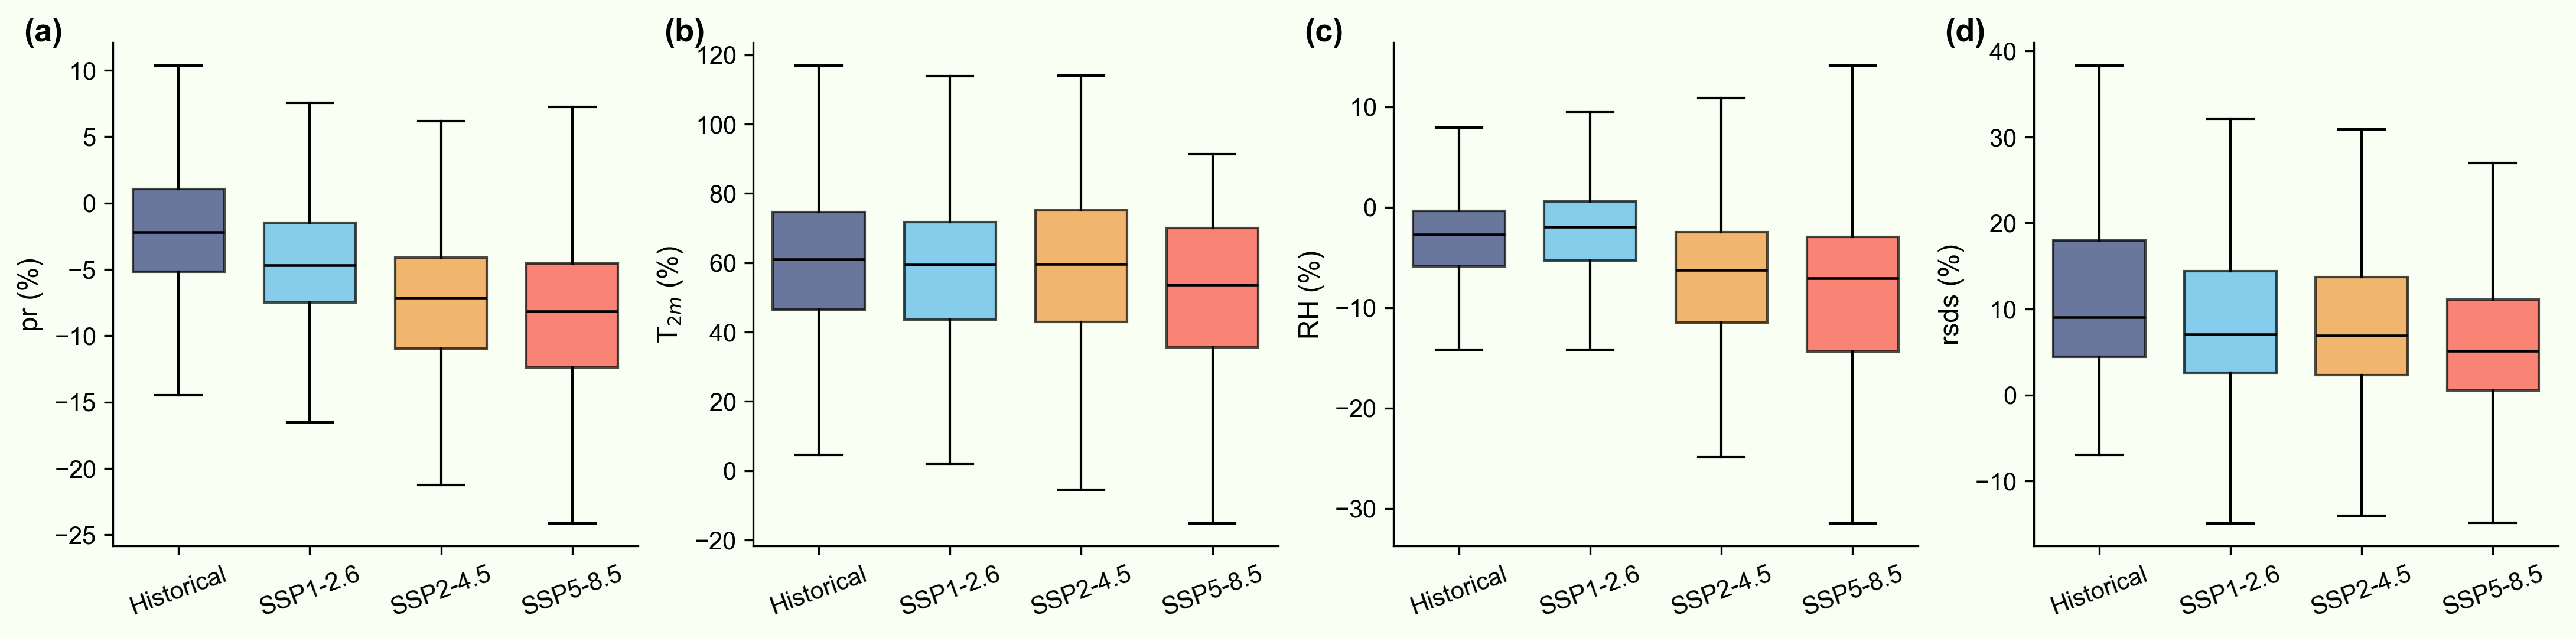

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

# Path and variables
base_dir = r"J:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj"
scenarios = ["historical", "ssp126", "ssp245", "ssp585"]
scenario_labels = ['Historical', 'SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5']
var_info = [
    {"prefix": "pr",   "ylabel": r'pr'},
    {"prefix": "tas",  "ylabel": r'T$_{2m}$'},
    {"prefix": "RH",   "ylabel": r'RH'},
    {"prefix": "rsds", "ylabel": r'rsds'}
]
letters = ['(a)', '(b)', '(c)', '(d)']

def read_tif_flat(tif_path):
    ds = gdal.Open(tif_path)
    arr = ds.ReadAsArray().astype(np.float32)
    if ds.GetRasterBand(1).GetNoDataValue() is not None:
        nodata = ds.GetRasterBand(1).GetNoDataValue()
        arr = arr[arr != nodata]
    arr = arr[~np.isnan(arr)]
    arr = arr[arr > -1e10]
    return arr * 100   # Convert to percentage

fig, axes = plt.subplots(1, 4, figsize=(15, 4), dpi=300, sharey=False)
plt.subplots_adjust(left=0.06, right=0.98, top=0.90, bottom=0.19, wspace=0.22)

# Set the background color for the entire figure
fig.patch.set_facecolor('#F9FFF3')

box_colors = ['#2B3E76', '#54B8E7', '#EF9836', '#FA4F3E']

for i, vinfo in enumerate(var_info):
    ax = axes[i]
    data_list = []
    for scen in scenarios:
        tifname = f"{vinfo['prefix']}_{scen}.tif"
        tifpath = os.path.join(base_dir, scen, tifname)
        arr = read_tif_flat(tifpath)
        arr = arr[(arr > -10000) & (arr < 10000)]
        data_list.append(arr)
    
    # Draw boxplots
    bplot = ax.boxplot(
        data_list, patch_artist=True, showfliers=False, widths=0.7,
        medianprops=dict(color='k', linewidth=1.1)
    )
    for patch, color in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(scenario_labels, fontsize=10, rotation=20)
    ax.set_ylabel(vinfo['ylabel'] + ' (%)', fontsize=11)
    ax.text(-0.17, 1.05, letters[i], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Set the background color for each subplot
    ax.set_facecolor('#F9FFF3')

plt.savefig(r"E:\phd_l1\Understanding record-shattering compound drought-heatwave dynamics and their severe ecosystem impacts\EF\Major Revision\Revised_figs\global_sensitivity_boxplots_perc.png", dpi=300, bbox_inches="tight")


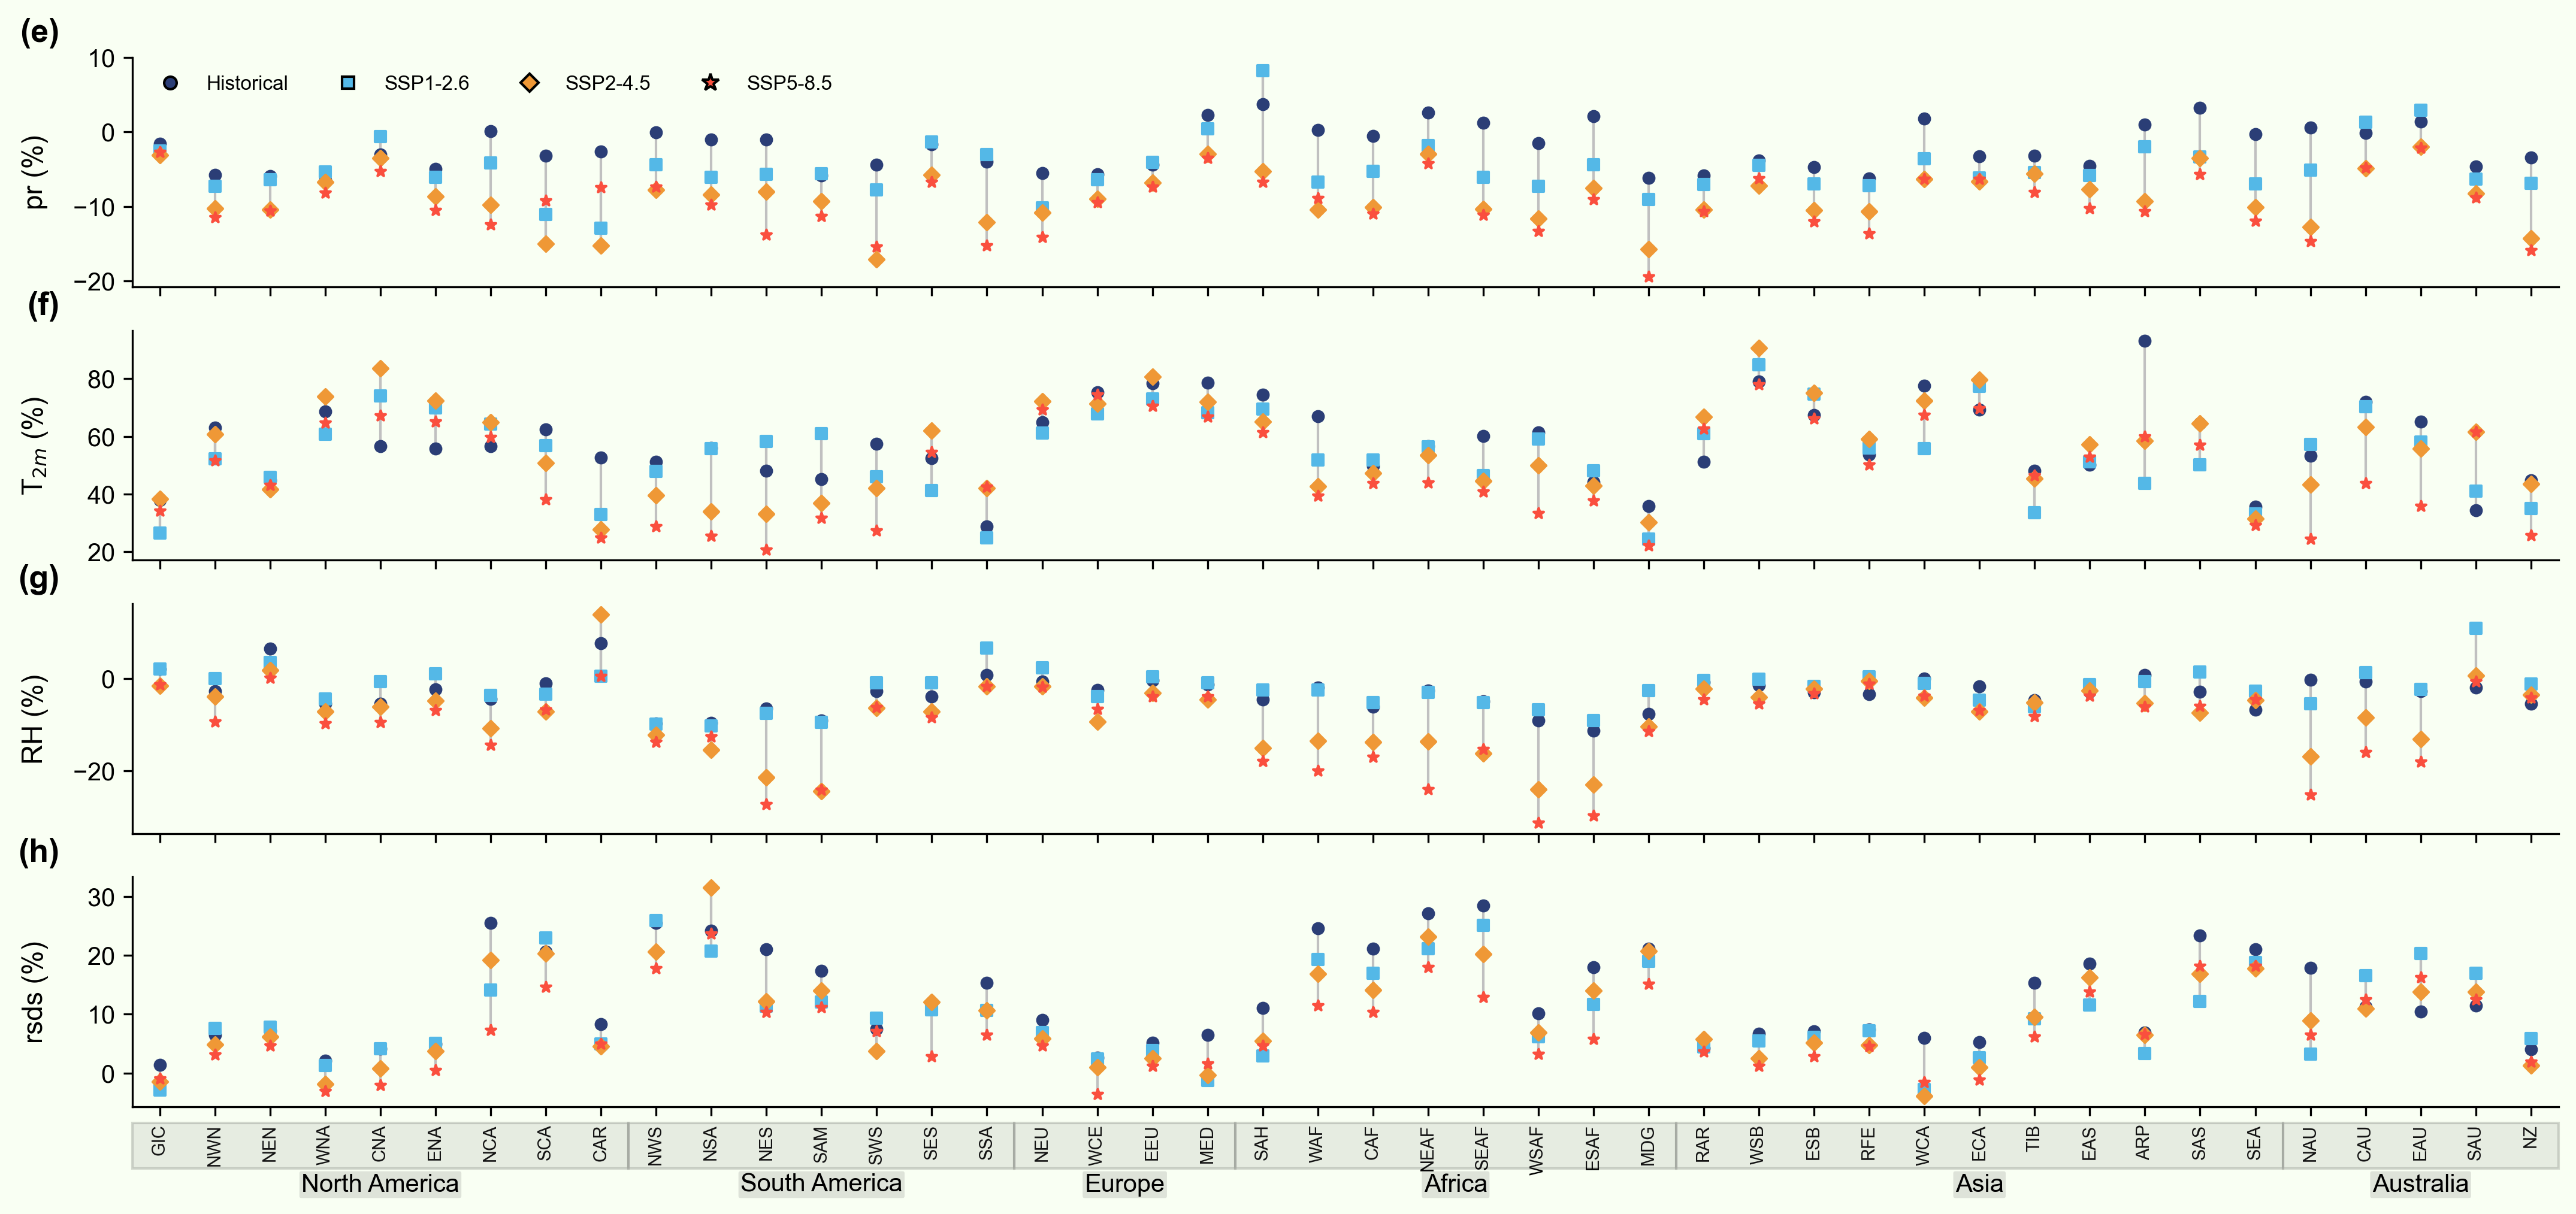

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

subcontinents = [
    'GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA',
    'NEU', 'WCE', 'EEU', 'MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG', 'RAR', 'WSB', 'ESB',
    'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'
]

data_dir = r"J:\CMIP6_eco\CDHW\sensitivities\zonal_stats"
files = {
    "historical": os.path.join(data_dir, "historical.xlsx"),
    "ssp126": os.path.join(data_dir, "ssp126.xlsx"),
    "ssp245": os.path.join(data_dir, "ssp245.xlsx"),
    "ssp585": os.path.join(data_dir, "ssp585.xlsx"),
}

var_info = [
    {"prefix": "pr",   "ylabel": r'pr (%)'},
    {"prefix": "tas",  "ylabel": r'T$_{2m}$ (%)'},
    {"prefix": "RH",   "ylabel": r'RH (%)'},
    {"prefix": "rsds", "ylabel": r'rsds (%)'}
]
scenarios = ["historical", "ssp126", "ssp245", "ssp585"]

def get_varname(var, scen):
    if scen == "historical":
        return f"{var}_historical"
    else:
        return f"{var}_{scen}"

colors = {
    "historical": "#2B3E76",
    "ssp126": "#54B8E7",
    "ssp245": "#EF9836",
    "ssp585": "#FA4F3E",
}
markers = {
    "historical": "o",
    "ssp126": "s",
    "ssp245": "D",
    "ssp585": "*",
}

# Create figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True, dpi=300)
plt.subplots_adjust(hspace=0.19, left=0.08, right=0.98, top=0.96, bottom=0.23)

# Set background color for the whole figure
fig.patch.set_facecolor('#F9FFF3')

labels = ['(e)', '(f)', '(g)', '(h)']

for ax_id, var in enumerate(var_info):
    data = {}
    for scen in scenarios:
        df = pd.read_excel(files[scen], index_col=0)
        varname = get_varname(var["prefix"], scen)
        data[scen] = df.loc[varname, subcontinents].values * 100

    x = range(len(subcontinents))
    ax = axes[ax_id]
    # Set background color for each subplot
    ax.set_facecolor('#F9FFF3')

    # Draw dumbbell lines and scatter points
    for i in x:
        yvals = [data[scen][i] for scen in scenarios]
        ax.plot([i] * 4, yvals, color="#c0c0c0", linewidth=1, zorder=1)
        for j, scen in enumerate(scenarios):
            ax.scatter(i, yvals[j], color=colors[scen], s=18, marker=markers[scen], zorder=2)

    # Auto-adjust y-axis
    ax.autoscale(enable=True, axis='y')
    ax.set_ylabel(var["ylabel"], fontsize=11, rotation=90, va='center')
    # Move ylabel closer to y-axis
    ax.yaxis.set_label_coords(-0.04, 0.5)

    # Remove top and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Set y-ticks for the first subplot only
    if ax_id == 0:
        ax.set_yticks([-20, -10, 0, 10])
    # Only show x-ticks for the last subplot
    if ax_id == 3:
        ax.set_xticks(list(x))
        ax.set_xticklabels(subcontinents, rotation=90, fontsize=7)
    else:
        ax.set_xticks([])

    # Add (a) (b) (c) (d) subplot labels
    ax.text(-0.03, 1.04, labels[ax_id], transform=ax.transAxes, fontsize=13, fontweight='bold', va='bottom', ha='right')

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker=markers["historical"], color='none', label='Historical', markerfacecolor=colors["historical"], markersize=5),
    Line2D([0], [0], marker=markers["ssp126"], color='none', label='SSP1-2.6', markerfacecolor=colors["ssp126"], markersize=5),
    Line2D([0], [0], marker=markers["ssp245"], color='none', label='SSP2-4.5', markerfacecolor=colors["ssp245"], markersize=5),
    Line2D([0], [0], marker=markers["ssp585"], color='none', label='SSP5-8.5', markerfacecolor=colors["ssp585"], markersize=7)
]
axes[0].legend(handles=legend_elements, fontsize=8, loc='upper left', ncol=4, frameon=False)

# Draw bottom continent blocks and labels (using normalized coordinates)
continent_blocks = [
    {"label": "North America", "start": "GIC", "end": "CAR"},
    {"label": "South America", "start": "NWS", "end": "SSA"},
    {"label": "Europe", "start": "NEU", "end": "MED"},
    {"label": "Africa", "start": "SAH", "end": "MDG"},
    {"label": "Asia", "start": "RAR", "end": "SEA"},
    {"label": "Australia", "start": "NAU", "end": "NZ"},
]
sub_len = len(subcontinents)
get_frac = lambda idx: idx / sub_len

for block in continent_blocks:
    x0 = subcontinents.index(block["start"])
    x1 = subcontinents.index(block["end"])
    frac_start = get_frac(x0)
    frac_end = get_frac(x1+1)
    frac_mid = (frac_start + frac_end) / 2
    # Draw rectangle for continent block
    rect = patches.Rectangle(
        (frac_start, -0.27),  # y negative, below x-axis
        frac_end - frac_start, 0.2,
        transform=axes[-1].transAxes,
        facecolor='gray', edgecolor='k', alpha=0.15, linewidth=1, zorder=10
    )
    fig.add_artist(rect)
    # Draw continent label
    props = dict(boxstyle='round', facecolor='gray', alpha=0.22, edgecolor="none", pad=0.08)
    axes[-1].text(frac_mid, -0.29, block["label"], fontsize=10, ha='center', va='top', transform=axes[-1].transAxes, bbox=props)

# Set x-axis limits for all subplots
for ax in axes:
    ax.set_xlim(-0.5, len(subcontinents)-0.5)


plt.savefig(r"E:\phd_l1\Understanding record-shattering compound drought-heatwave dynamics and their severe ecosystem impacts\EF\Major Revision\Revised_figs\multi_var_sensitivity_dumbbell_with_continents_axes.png", dpi=300, bbox_inches="tight")
